<a href="https://colab.research.google.com/github/woojoo123/Project/blob/main/Psychological_counseling_chatbot/KoELECTRA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# 한글 폰트
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 29 not upgraded.
Need to get 10.3 MB of archives.
After this operation, 34.1 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 fonts-nanum all 20200506-1 [10.3 MB]
0% [1 fonts-nanum 14.2 kB/10.3 MB 0%]^C
^C


# 데이터 로드

In [ ]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 485.4/485.4 kB 18.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 13.7 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from sklearn.model_selection import train_test_split
from datasets import Dataset

In [ ]:
import pandas as pd

df = pd.read_csv('/content/drive/MyDrive/프로젝트/심리상담 챗봇/data/emotional_corpus.csv')
df

,emotion,text
0,분노,일은 왜 해도 해도 끝이 없을까? 화가 난다.
1,분노,이번 달에 또 급여가 깎였어! 물가는 오르는데 월급만 자꾸 깎이니까 너무 화가 나.
2,분노,회사에 신입이 들어왔는데 말투가 거슬려. 그런 애를 매일 봐야 한다고 생각하니까 스...
3,분노,직장에서 막내라는 이유로 나에게만 온갖 심부름을 시켜. 일도 많은 데 정말 분하고 ...
4,분노,얼마 전 입사한 신입사원이 나를 무시하는 것 같아서 너무 화가 나.
...,...,...
163918,분노,말해봐도 소용이 없어.
163919,기쁨,부모님께는 자주 찾아뵙는 게 우선일 거고 남편에겐 힘낼 수 있는 말을 자주 해 줄 ...
163920,불안,좋아하는 노래를 한 곡 듣고 기분이 나아진 상태에서 친구들과 대화를 하면 좋을 것 같아.
163921,기쁨,함께 점심도 먹고 친하게 지내고 있어.


# 감정 라벨 정수인코딩

In [ ]:
label_map = {"분노": 0, "불안": 1, "상처": 2, "슬픔": 3, "당황": 4, "기쁨": 5}
df["label"] = df["emotion"].map(label_map)

In [ ]:
df

,emotion,text,label
0,분노,일은 왜 해도 해도 끝이 없을까? 화가 난다.,0
1,분노,이번 달에 또 급여가 깎였어! 물가는 오르는데 월급만 자꾸 깎이니까 너무 화가 나.,0
2,분노,회사에 신입이 들어왔는데 말투가 거슬려. 그런 애를 매일 봐야 한다고 생각하니까 스...,0
3,분노,직장에서 막내라는 이유로 나에게만 온갖 심부름을 시켜. 일도 많은 데 정말 분하고 ...,0
4,분노,얼마 전 입사한 신입사원이 나를 무시하는 것 같아서 너무 화가 나.,0
...,...,...,...
163918,분노,말해봐도 소용이 없어.,0
163919,기쁨,부모님께는 자주 찾아뵙는 게 우선일 거고 남편에겐 힘낼 수 있는 말을 자주 해 줄 ...,5
163920,불안,좋아하는 노래를 한 곡 듣고 기분이 나아진 상태에서 친구들과 대화를 하면 좋을 것 같아.,1
163921,기쁨,함께 점심도 먹고 친하게 지내고 있어.,5


# 데이터 분리

In [ ]:
# 3. Train / Validation / Test로 데이터 분리
train_texts, temp_texts, train_labels, temp_labels = train_test_split(
    df["text"], df["label"], test_size=0.2, random_state=42  # 80% Train, 20% Validation + Test
)

val_texts, test_texts, val_labels, test_labels = train_test_split(
    temp_texts, temp_labels, test_size=0.5, random_state=42  # 10% Validation, 10% Test
)

In [ ]:
print(f'훈련 데이터 개수 : {len(train_texts)}')
print(f'훈련 데이터 개수 : {len(val_texts)}')
print(f'훈련 데이터 개수 : {len(test_texts)}')

훈련 데이터 개수 : 131138
훈련 데이터 개수 : 16392
훈련 데이터 개수 : 16393


# 데이터셋 변환

In [ ]:
train_dataset = Dataset.from_dict({"text": train_texts.tolist(), "label": train_labels.tolist()})
val_dataset = Dataset.from_dict({"text": val_texts.tolist(), "label": val_labels.tolist()})
test_dataset = Dataset.from_dict({"text": test_texts.tolist(), "label": test_labels.tolist()})

In [ ]:
train_dataset

Dataset({
    features: ['text', 'label'],
    num_rows: 131138
})

# 텍스트별 토큰 수 확인

In [ ]:
import pandas as pd
from transformers import AutoTokenizer

# 토크나이저 로드
tokenizer = AutoTokenizer.from_pretrained("monologg/koelectra-base-v3-discriminator")

# 텍스트 데이터를 토큰화하고 길이 계산
df["token_length"] = df["text"].apply(lambda x: len(tokenizer.tokenize(x)))

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/61.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/467 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/263k [00:00<?, ?B/s]

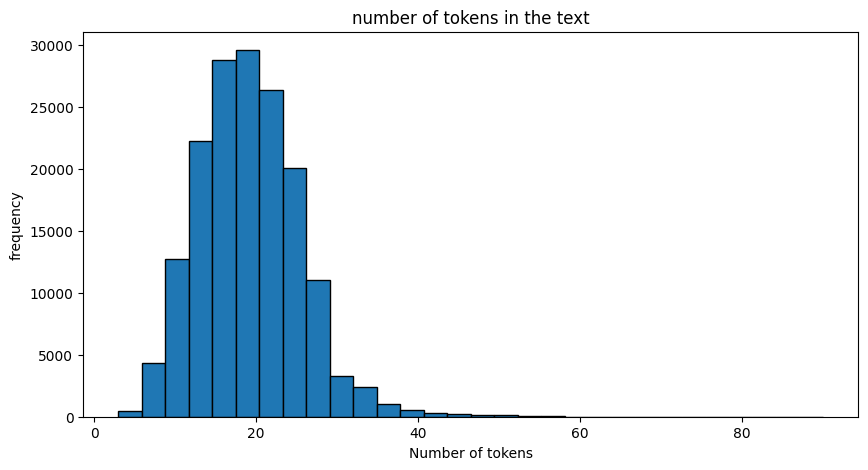

count    163923.000000
mean         19.209458
std           6.438175
min           3.000000
25%          15.000000
50%          19.000000
75%          23.000000
max          90.000000
Name: token_length, dtype: float64


In [ ]:
import matplotlib.pyplot as plt
plt.rc('font', family='NanumBarunGothic')
plt.rcParams['axes.unicode_minus'] =False

# 토큰 길이 분포 확인
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.hist(df["token_length"], bins=30, edgecolor='black')
plt.xlabel("Number of tokens")
plt.ylabel("frequency")
plt.title("number of tokens in the text")
plt.show()

# 통계 정보 출력
print(df["token_length"].describe())

In [ ]:
# 60개 이상인 샘플 개수 계산
num_over_60 = (df["token_length"] >= 60).sum()

# 결과 출력
print(f"토큰 개수가 60개 이상인 샘플 개수: {num_over_60}")

토큰 개수가 60개 이상인 샘플 개수: 21


In [ ]:
df

,emotion,text,label,token_length
0,분노,일은 왜 해도 해도 끝이 없을까? 화가 난다.,0,13
1,분노,이번 달에 또 급여가 깎였어! 물가는 오르는데 월급만 자꾸 깎이니까 너무 화가 나.,0,24
2,분노,회사에 신입이 들어왔는데 말투가 거슬려. 그런 애를 매일 봐야 한다고 생각하니까 스...,0,24
3,분노,직장에서 막내라는 이유로 나에게만 온갖 심부름을 시켜. 일도 많은 데 정말 분하고 ...,0,27
4,분노,얼마 전 입사한 신입사원이 나를 무시하는 것 같아서 너무 화가 나.,0,21
...,...,...,...,...
163918,분노,말해봐도 소용이 없어.,0,7
163919,기쁨,부모님께는 자주 찾아뵙는 게 우선일 거고 남편에겐 힘낼 수 있는 말을 자주 해 줄 ...,5,30
163920,불안,좋아하는 노래를 한 곡 듣고 기분이 나아진 상태에서 친구들과 대화를 하면 좋을 것 같아.,1,30
163921,기쁨,함께 점심도 먹고 친하게 지내고 있어.,5,12


# 토큰화

In [ ]:
model_name = "monologg/koelectra-base-v3-discriminator"
tokenizer = AutoTokenizer.from_pretrained(model_name)

def tokenize_function(examples):
    return tokenizer(examples["text"], truncation=True, padding="max_length", max_length=60)

train_dataset = train_dataset.map(tokenize_function, batched=True)
val_dataset = val_dataset.map(tokenize_function, batched=True)
test_dataset = test_dataset.map(tokenize_function, batched=True)

Map:   0%|          | 0/131138 [00:00<?, ? examples/s]

Map:   0%|          | 0/16392 [00:00<?, ? examples/s]

Map:   0%|          | 0/16393 [00:00<?, ? examples/s]

In [ ]:
train_dataset

Dataset({
    features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 131138
})

In [ ]:
train_dataset = train_dataset.remove_columns(["text", "token_type_ids"])
val_dataset = val_dataset.remove_columns(["text", "token_type_ids"])
test_dataset = test_dataset.remove_columns(["text", "token_type_ids"])

In [ ]:
train_dataset

Dataset({
    features: ['label', 'input_ids', 'attention_mask'],
    num_rows: 131138
})

# 모델 학습

In [ ]:
# 모델 불러오기

from transformers import AutoModelForSequenceClassification
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=6)

pytorch_model.bin:   0%|          | 0.00/452M [00:00<?, ?B/s]

Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at monologg/koelectra-base-v3-discriminator and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
!pip install evaluate

model.safetensors:   0%|          | 0.00/452M [00:00<?, ?B/s]

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 5.1 MB/s eta 0:00:00


In [ ]:
# 학습 설정

from transformers import Trainer, TrainingArguments, EarlyStoppingCallback
import evaluate

f1_metric = evaluate.load("f1")
accuracy_metric = evaluate.load("accuracy")
precision_metric = evaluate.load("precision")
recall_metric = evaluate.load("recall")

def custom_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)

    f1_score = f1_metric.compute(predictions=preds, references=labels, average="micro")["f1"]
    accuracy = accuracy_metric.compute(predictions=preds, references=labels)["accuracy"]
    precision = precision_metric.compute(predictions=preds, references=labels, average="micro")["precision"]
    recall = recall_metric.compute(predictions=preds, references=labels, average="micro")["recall"]

    return {
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1": f1_score,
    }


training_args = TrainingArguments(
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    learning_rate=5e-5,
    max_grad_norm=1,
    num_train_epochs=5,
    evaluation_strategy='steps',
    logging_strategy='steps',
    logging_steps=1000,
    logging_dir='/content/drive/MyDrive/프로젝트/심리상담 챗봇/KoELECTRA/logs',
    save_strategy='steps',
    save_steps=1000,
    output_dir='/content/drive/MyDrive/프로젝트/심리상담 챗봇/KoELECTRA/',
    load_best_model_at_end=True,
    metric_for_best_model='f1',
    greater_is_better=True,
    report_to='tensorboard'
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    compute_metrics=custom_metrics,
    callbacks = [EarlyStoppingCallback(early_stopping_patience=3)]
)

/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-20-5a19b76403bb>:47: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [ ]:
trainer.train()

Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1000,1.553700,1.785602,0.183931,0.183931,0.183931,0.183931
2000,1.422900,1.364105,0.464800,0.464800,0.464800,0.464800
3000,1.342900,1.311813,0.483651,0.483651,0.483651,0.483651
4000,1.315600,1.301478,0.487311,0.487311,0.487311,0.487311
5000,1.233800,1.301678,0.492008,0.492008,0.492008,0.492008
6000,1.231200,1.297369,0.491154,0.491154,0.491154,0.491154
7000,1.223600,1.290034,0.491215,0.491215,0.491215,0.491215
8000,1.223200,1.277991,0.505002,0.505002,0.505002,0.505002
9000,1.120600,1.335333,0.504453,0.504453,0.504453,0.504453
10000,1.085300,1.333153,0.502074,0.502074,0.502074,0.502074


TrainOutput(global_step=14000, training_loss=1.2007105146135604, metrics={'train_runtime': 5379.2129, 'train_samples_per_second': 121.893, 'train_steps_per_second': 3.81, 'total_flos': 1.38110514046056e+16, 'train_loss': 1.2007105146135604, 'epoch': 3.4154671871188094})

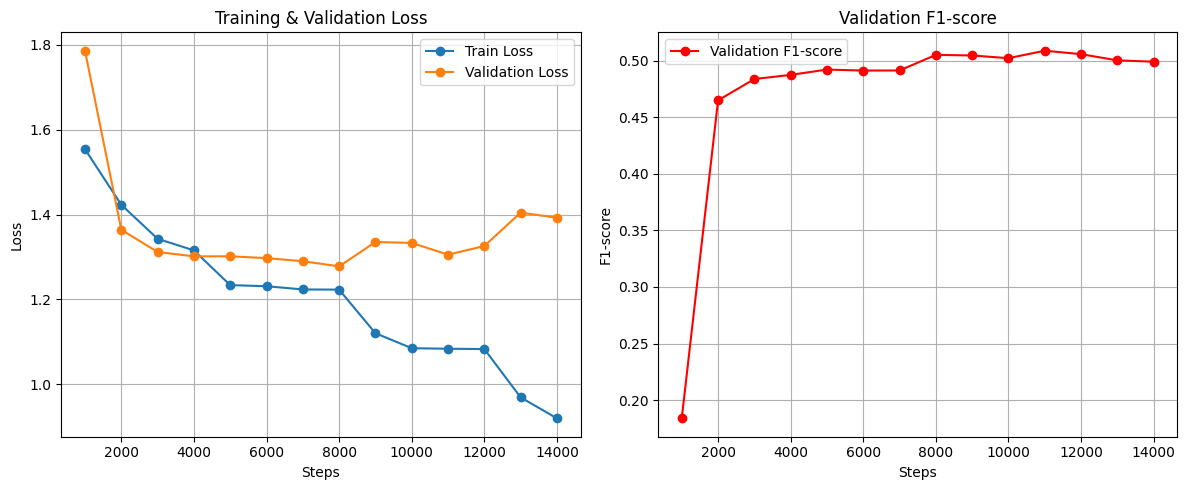

In [ ]:
import matplotlib.pyplot as plt

# Trainer의 로그 히스토리에서 필요한 데이터 추출
history = trainer.state.log_history

# loss 및 f1-score 저장용 리스트
train_losses = []
eval_losses = []
eval_f1_scores = []
steps = []

for log in history:
    if 'loss' in log:  # Training loss
        train_losses.append(log['loss'])
        steps.append(log['step'])
    if 'eval_loss' in log:  # Validation loss
        eval_losses.append(log['eval_loss'])
    if 'eval_f1' in log:  # Validation f1-score
        eval_f1_scores.append(log['eval_f1'])

# 그래프 그리기
plt.figure(figsize=(12, 5))

# Loss 그래프
plt.subplot(1, 2, 1)
plt.plot(steps[:len(train_losses)], train_losses, label="Train Loss", marker='o')
plt.plot(steps[:len(eval_losses)], eval_losses, label="Validation Loss", marker='o')
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.title("Training & Validation Loss")
plt.legend()
plt.grid()

# F1-score 그래프
plt.subplot(1, 2, 2)
plt.plot(steps[:len(eval_f1_scores)], eval_f1_scores, label="Validation F1-score", marker='o', color='red')
plt.xlabel("Steps")
plt.ylabel("F1-score")
plt.title("Validation F1-score")
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

In [ ]:
best_checkpoint = trainer.state.best_model_checkpoint
print(f"Best model checkpoint: {best_checkpoint}")

Best model checkpoint: /content/drive/MyDrive/프로젝트/심리상담 챗봇/KoELECTRA/checkpoint-11000


In [ ]:
# 모델 저장 (Trainer 방식)
trainer.save_model("/content/drive/MyDrive/프로젝트/심리상담 챗봇/KoELECTRA/best_model")

# 모델 평가

In [ ]:
predictions = trainer.predict(test_dataset)
print(predictions.metrics)

{'test_loss': 1.303816318511963, 'test_accuracy': 0.5101567742329043, 'test_precision': 0.5101567742329043, 'test_recall': 0.5101567742329043, 'test_f1': 0.5101567742329043, 'test_runtime': 54.6619, 'test_samples_per_second': 299.898, 'test_steps_per_second': 9.385}


In [ ]:
df

,emotion,text,label,token_length
0,분노,일은 왜 해도 해도 끝이 없을까? 화가 난다.,0,13
1,분노,이번 달에 또 급여가 깎였어! 물가는 오르는데 월급만 자꾸 깎이니까 너무 화가 나.,0,24
2,분노,회사에 신입이 들어왔는데 말투가 거슬려. 그런 애를 매일 봐야 한다고 생각하니까 스...,0,24
3,분노,직장에서 막내라는 이유로 나에게만 온갖 심부름을 시켜. 일도 많은 데 정말 분하고 ...,0,27
4,분노,얼마 전 입사한 신입사원이 나를 무시하는 것 같아서 너무 화가 나.,0,21
...,...,...,...,...
163918,분노,말해봐도 소용이 없어.,0,7
163919,기쁨,부모님께는 자주 찾아뵙는 게 우선일 거고 남편에겐 힘낼 수 있는 말을 자주 해 줄 ...,5,30
163920,불안,좋아하는 노래를 한 곡 듣고 기분이 나아진 상태에서 친구들과 대화를 하면 좋을 것 같아.,1,30
163921,기쁨,함께 점심도 먹고 친하게 지내고 있어.,5,12


In [ ]:
{"분노": 0, "불안": 1, "상처": 2, "슬픔": 3, "당황": 4, "기쁨": 5}

In [ ]:
import torch

# 사용 가능한 디바이스 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# 데이터프레임에서 처음 10개 텍스트 추출
texts = df["text"][:10].tolist()

# 토크나이징 및 입력 텐서 변환 (디바이스로 이동)
inputs = tokenizer(texts, padding=True, truncation=True, return_tensors="pt").to(device)

# 모델을 평가 모드로 변경
model.eval()

# 예측 수행
with torch.no_grad():
    outputs = model(**inputs)

# 가장 높은 확률의 클래스 선택
predicted_labels = torch.argmax(outputs.logits, dim=-1).tolist()

# 레이블 매핑
label_map = {0: "분노", 1: "불안", 2: "상처", 3: "슬픔", 4: "당황", 5: "기쁨"}
predicted_emotions = [label_map[label] for label in predicted_labels]

# 결과 출력
print("예측된 감정 결과:")
for i, emotion in enumerate(predicted_emotions):
    print(f"{i+1}. {emotion}")

예측된 감정 결과:
1. 분노
2. 분노
3. 분노
4. 분노
5. 분노
6. 슬픔
7. 분노
8. 기쁨
9. 기쁨
10. 기쁨


In [ ]:
df['emotion'][:10]

,emotion
0,분노
1,분노
2,분노
3,분노
4,분노
5,분노
6,분노
7,기쁨
8,불안
9,기쁨
